# Sberbank Russian Housing Market Analysis

This analysis is based on real estate market data collected by Sberbank in Moscow, Russia.  The dataset includes a list of property sales from August 2011 to June 2015.  For each sale, a number of real estate, geographic, and macro-economic features are provided.  The goal is to predict the sale price based on these features.  The algorithm developed here has been used on data from July 2015 to May 2016 as part of the [Sberbank Russian Housing Market Competition on Kaggle](https://www.kaggle.com/c/sberbank-russian-housing-market).

## Feature summary
### Real Estate
  * Area of property, living area, kitchen area
  * Number of rooms
  * Floor of property, and maximum floor of apartment building
  * Wall material
  * Build year
  * Condition of property
  * Sale type: for investment, or owner-occupier
  * Price of sale

### Neighborhood
  * District (location)
  * Population of district by age, gender, and employment
  * Number of buildings by build year
  * Number and distance to closest cafe, shopping mall, transportation hub, green zone, power plant
  * Distance to major roads and city center
  * Distance to education centers
  * Number of major cultural centers and tourist attractions in district

### Macro economic
  * GDP stats
  * Foreign exchange rates
  * Brent crude oil
  * Mortgage rates
  * Size of labor force and unemployment rate
  * Rent prices by apartment size
  

# Dataset and initial observations

Let's begin the analysis!  We will start by importing the dataset and tools we need, and then take a look at some of the main features.  Some of the strategies here have been tested and developed in other notebooks.  In this notebook we bring it all together.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing
import geopandas as gpd
import pysal
import random
import math

In [2]:
# import data
data = pd.read_csv("../input/train.csv", parse_dates=['timestamp']).set_index('id')

# import latitude, longitude coordinates for each property
# provided by Chippy at https://www.kaggle.com/nigelcarpenter/sberbankmoscowroads
latlon_data = pd.read_csv("../sberbankmoscowroads/train_lat_lon.csv").set_index('id')

# remove 'key' and 'tolerance_m' columns
latlon_data = latlon_data.drop(['key','tolerance_m'],1)

# merge into dataset
data['lat'] = np.NaN
data['lon'] = np.NaN
data.update(latlon_data)

print('Columns: ', data.shape[1])
print('Entries: ', data.shape[0])

# view the dataframe
pd.set_option('display.max_columns', None)
data.head()

Columns:  293
Entries:  30471


,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

## Feature exploration

Let's look at the distributions of some of our main features.

In [3]:
# Moscow by district
# shapefile provided by http://gis-lab.info/qa/moscow-atd.html
# and adapted for this dataset at https://github.com/JTremoureux/Kaggle_SRHM/tree/master/shp_mo_kag_SRHM
geo_df = gpd.read_file('../input/SRHM/mo_kag_SRHM.shp')

# get median price and number of sales per district
geo_df['median_price'] = np.NaN
geo_df['num_sales'] = np.NaN
for i, row in geo_df.iterrows():
    geo_df.set_value(i, 'median_price',
                     data[ data['sub_area'] == row['sub_area'] ].price_doc.median()/1e6)
    geo_df.set_value(i, 'num_sales',
                     len(data[ data['sub_area'] == row['sub_area'] ]))

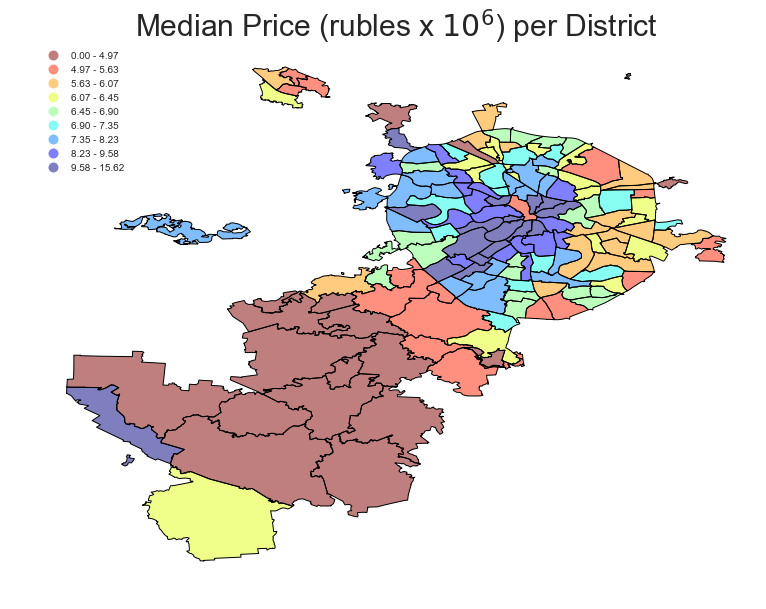

In [4]:
# plot median price
fig, ax = plt.subplots(1, figsize=(13, 10))
geo_df.plot(column='median_price', cmap='jet_r',
            legend=True, scheme='QUANTILES', k=9, ax=ax)
ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0.8, 0.4, 0.2))
plt.title('Median Price (rubles x $10^6$) per District', fontsize=30)
plt.show()

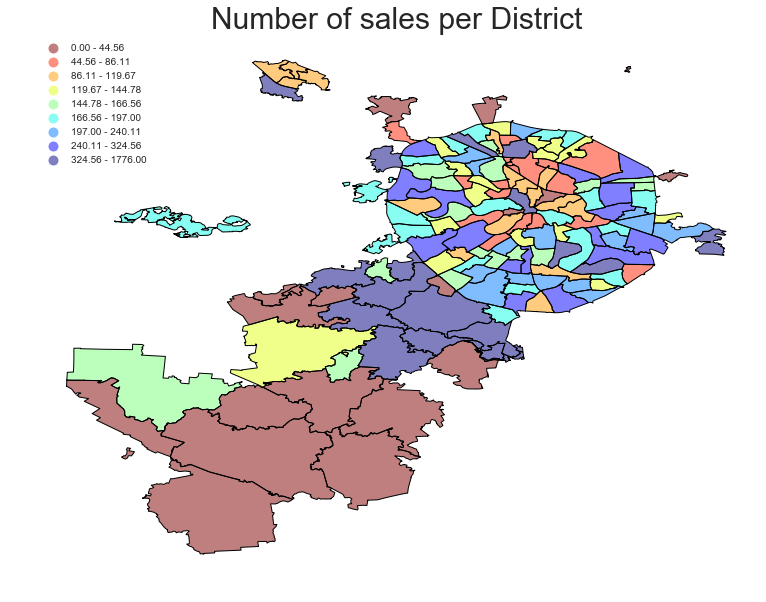

In [5]:
# plot number of sales
fig, ax = plt.subplots(1, figsize=(13, 10))
geo_df.plot(column='num_sales', cmap='jet_r',
            legend=True, scheme='QUANTILES', k=9, ax=ax)
ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0.8, 0.4, 0.2))
plt.title('Number of sales per District', fontsize=30)
plt.show()

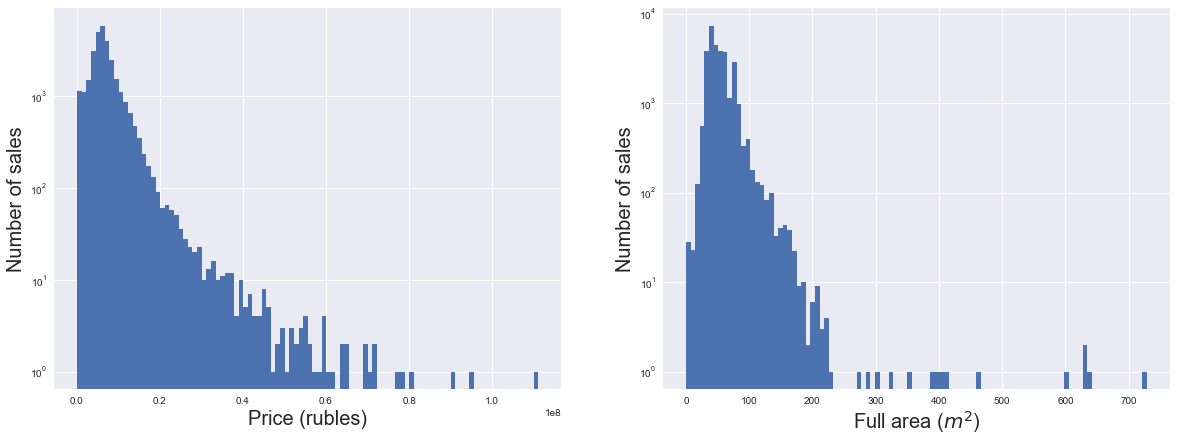

In [6]:
plt.figure(figsize=(20, 7))

# distribution of price
plt.subplot(1,2,1)
plt.hist(data['price_doc'], bins=100)
plt.xlabel('Price (rubles)', fontsize=20)
plt.ylabel('Number of sales', fontsize=20)
plt.yscale('log')

# distribution of property area
plt.subplot(1,2,2)
plt.hist(data[ data['full_sq'] < 1e3 ].full_sq, bins=100)
plt.xlabel('Full area ($m^2$)', fontsize=20)
plt.ylabel('Number of sales', fontsize=20)
plt.yscale('log')

plt.show()

## Anomalous feature values

Some feature values in this dataset have unrealistic or NaN values.  Examples include properties with an area of less than 10 $m^2$, or apartments on a floor above the maximum building floor.  Some values are set to 1 or 0 as a placeholder for 'NaN'.

### Example: investment sale prices
An interesting example of this is shown below.  Let's look at low end of the sale price spectrum.

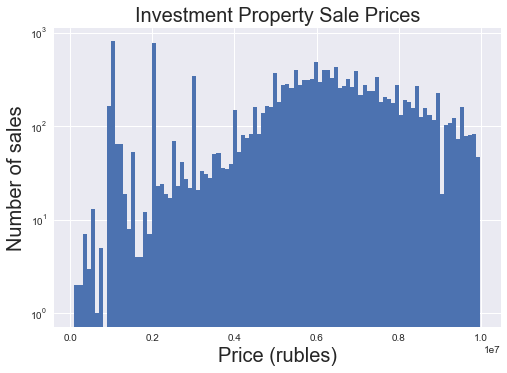

In [7]:
# distribution of price
plt.figure()
plt.hist(data[ (data['price_doc'] < 1e7) & (data['product_type'] == 'Investment') ].price_doc, bins=100)
plt.title('Investment Property Sale Prices', fontsize=20)
plt.xlabel('Price (rubles)', fontsize=20)
plt.ylabel('Number of sales', fontsize=20)
plt.yscale('log')
plt.show()

We can see that there is an excess of sales with prices of exactly 1, 2, and 3 million rubles.  Why is that?

It turns out that prices are sometimes artificially reduced in investment purchases for tax puposes.  For the analysis, we will keep these sales in the dataset, but provide some distinction between investment and owner-occupier properties when training our model.


### Other anomalous values

We have explored these features in other notebooks.  The results of our findings are used here to clean the dataset.

Our machine learning model (XGBoost) has automatic handling for NaN values.  So we will set some of the anomalous values to NaN.

In [8]:
# for max_floor > 47 and max_floor == 0, set to NaN
# (the tallest building in Moscow is 47 floors)
data.loc[data['max_floor'] > 47, 'max_floor'] = np.NaN
data.loc[data['max_floor'] == 0, 'max_floor'] = np.NaN

# for floor > 47, set to NaN
data.loc[data['max_floor'] < data['floor'], 'max_floor'] = np.NaN
data.loc[data['floor'] > 47, 'floor'] = np.NaN

# fix anomalous build_year
data.loc[data['build_year'] == 1691, 'build_year'] = 1961
data.loc[data['build_year'] == 215, 'build_year'] = 2015
data.loc[data['build_year'] == 4965, 'build_year'] = 1965
data.loc[data['build_year'] == 2, 'build_year'] = 2014
data.loc[data['build_year'] == 3, 'build_year'] = 2013
data.loc[data['build_year'] == 20, 'build_year'] = 2014
data.loc[data['build_year'] == 20052009, 'build_year'] = 2009
data.loc[data['build_year'] == 0, 'build_year'] = np.NaN
data.loc[data['build_year'] == 1, 'build_year'] = np.NaN
data.loc[data['build_year'] == 71, 'build_year'] = np.NaN

# quick fix for anomalous full_sq
data.loc[data['full_sq'] > 1000, 'full_sq'] = data['full_sq']/100
data.loc[data['full_sq'] > 250, 'full_sq'] = data['full_sq']/10
data.loc[data['full_sq'] < 20, 'full_sq'] = np.NaN

# do the same with life_sq
data.loc[data['life_sq'] > 1000, 'life_sq'] = data['life_sq']/100
data.loc[data['life_sq'] > 250, 'life_sq'] = data['life_sq']/10
data.loc[data['life_sq'] < 10, 'life_sq'] = np.NaN

In [9]:
# fill in missing full_sq, life_sq, kitch_sq
# using simple linear regressions
for i, row in data.iterrows():
    if np.isnan(row['full_sq']) & np.isfinite(row['life_sq']) & np.isfinite(row['kitch_sq']):
        data.set_value(i, 'full_sq', 1.15 + 1.33*(row['life_sq']+row['kitch_sq']) )
    if np.isnan(row['life_sq']) & np.isfinite(row['full_sq']) & np.isfinite(row['kitch_sq']):
        data.set_value(i, 'life_sq', (row['full_sq']-1.15)/1.33 - row['kitch_sq'] )
    if np.isnan(row['kitch_sq']) & np.isfinite(row['full_sq']) & np.isfinite(row['life_sq']):
        data.set_value(i, 'kitch_sq', (row['full_sq']-1.15)/1.33 - row['life_sq'] )
    if np.isnan(row['full_sq']) & np.isfinite(row['life_sq']) & np.isnan(row['kitch_sq']):
        data.set_value(i, 'full_sq', 9.27 + 1.41*(row['life_sq']) )
    if np.isnan(row['life_sq']) & np.isfinite(row['full_sq']) & np.isnan(row['kitch_sq']):
        data.set_value(i, 'life_sq', (row['full_sq']-9.27)/1.41 )

data.loc[data['life_sq'] < 0, 'life_sq'] = np.NaN

In [10]:
# drop several entries with extreme values of price per area
data = data[ (data['price_doc']/data['full_sq'] < 1e6) ]

## Feature engineering

Add some features that improve our regression model.

In [11]:
# Add month-year
month_year = (data.timestamp.dt.month + data.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
data['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (data.timestamp.dt.weekofyear + data.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
data['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
data['month'] = data.timestamp.dt.month
data['dow'] = data.timestamp.dt.dayofweek

# Other feature engineering
data['rel_floor'] = data['floor'] / data['max_floor'].astype(float)
data['rel_kitch_sq'] = data['kitch_sq'] / data['full_sq'].astype(float)
data['room_size'] = data['life_sq'] / data['num_room'].astype(float)

data.drop(['timestamp'], axis=1, inplace=True)

### Convert categorical features to numerical

In [12]:
# separate numerical and categorical features
categorical_features = data.select_dtypes(include = ['object']).columns
numerical_features = data.select_dtypes(exclude = ['object']).columns

print('Numerical features : ' + str(len(numerical_features)))
print('Categorical features : ' + str(len(categorical_features)))
data_num = data[numerical_features]
data_cat = data[categorical_features]

print('List of categorical features:')
print(categorical_features.values)

# create dummy features for categorical values via one-hot encoding
data_cat = pd.get_dummies(data_cat,columns=data_cat.columns)

# join categorical and numerical features
data = pd.concat([data_num, data_cat], axis=1)

Numerical features : 284
Categorical features : 15
List of categorical features:
['product_type' 'sub_area' 'culture_objects_top_25'
 'thermal_power_plant_raion' 'incineration_raion' 'oil_chemistry_raion'
 'radiation_raion' 'railroad_terminal_raion' 'big_market_raion'
 'nuclear_reactor_raion' 'detention_facility_raion' 'water_1line'
 'big_road1_1line' 'railroad_1line' 'ecology']


# Training and test dataset

We split our dataset into 70% training data, and 30% test data.  In the Sberbank competition, we have an independent test dataset, so an additional 'validation' dataset isn't needed.

Instead of using the standard scikit-learn method for train-test splitting, we will use a simple random number generator.  Slightly more convenient for now, since the train and test data can stay in the same dataframe.

In [13]:
data['testdata'] = False
indexes = data.index

print('Total entries: ', len(indexes))
num_train = math.floor(0.7*len(indexes))
num_test = len(indexes) - num_train
print('Train entries: ', num_train)

random.seed(71)
indexes_test = random.sample(list(indexes), num_test)

data.set_value(indexes_test, 'testdata', True)
print('Test entries: ', len(data[ data['testdata'] == True ]))

Total entries:  30431
Train entries:  21301
Test entries:  9130


# Geographic pricing interpolation

A very important effect to capture in our model is the dependence of price on the location of the property.  We will go about this by interpolating the price/area in the vicinity of each property.  That provides a baseline for the price/area, which will be refined later in the XGBoost model.

The interpolation is conducted with a simple exponential function.  This function is used to compute a weight, which then enters into a weighted average price/area.

In [14]:
# interpolation weight
def wexp(lat0, lon0, lati, loni, tol):
    dist = np.sqrt((lati-lat0)**2+(loni-lon0)**2)
    return np.exp(-dist/tol)

# for each property, find weighted average of price/area
# of surrounding properties
count = 0
def fexp(row):
    global count
    i = row.name
    count = count + 1
    if( count % 5000 == 0 ):
        print('Processing entry ', count)
    
    lat = row['lat']
    lon = row['lon']
    
    w = wexp(row['lat'], row['lon'], tmp['lat'], tmp['lon'], tol)
    price_sum = (w*(tmp['price_doc']/tmp['full_sq'])).sum()
    wsum = w.sum()
    
    # if training data, remove current entry for the price/sq interpolation
    if row['testdata'] == False:
        row_price = row['price_doc']/row['full_sq'] if (row['full_sq'] != 0) else 0
        if row_price != 0:
            price_sum = price_sum - row_price
            wsum = wsum - 1
        else:
            print('INVALID ROW PRICE ', i, row_price )

    price_avg = price_sum/wsum if ((price_sum != 0) & (wsum != 0)) else price_tavg
    return price_avg

data['psq_interp'] = (data[ data['testdata'] == False ].price_doc/data[ data['testdata'] == False ].full_sq).mean()

# interpolation for investment properties
tol = 0.01
tmp = data[ (data['product_type_Investment'] == 1) & (data['testdata'] == False) ]
tmpdata = data[ (data['product_type_Investment'] == 1) ]
price_tavg = (tmp['price_doc']/tmp['full_sq']).mean()
data.loc[data['product_type_Investment'] == 1, 'psq_interp'] = tmpdata.apply(fexp, axis=1)

# interpolation for owner-occupier properties
tol = 0.003
tmp = data[ (data['product_type_Investment'] == 0) & (data['testdata'] == False) ]
tmpdata = data[ (data['product_type_Investment'] == 0) ]
price_tavg = (tmp['price_doc']/tmp['full_sq']).mean()
data.loc[data['product_type_Investment'] == 0, 'psq_interp'] = tmpdata.apply(fexp, axis=1)

data['price_interp'] = data['psq_interp']*data['full_sq']

Processing entry  5000
Processing entry  10000
Processing entry  15000
Processing entry  20000
Processing entry  25000
Processing entry  30000


## Interpolation results

We conducted the interpolation for investment and owner-occupier properties separately, with slightly different lengthscales set by the 'tol' parameter.  Let's see what the combined interpolation looks like for each property.

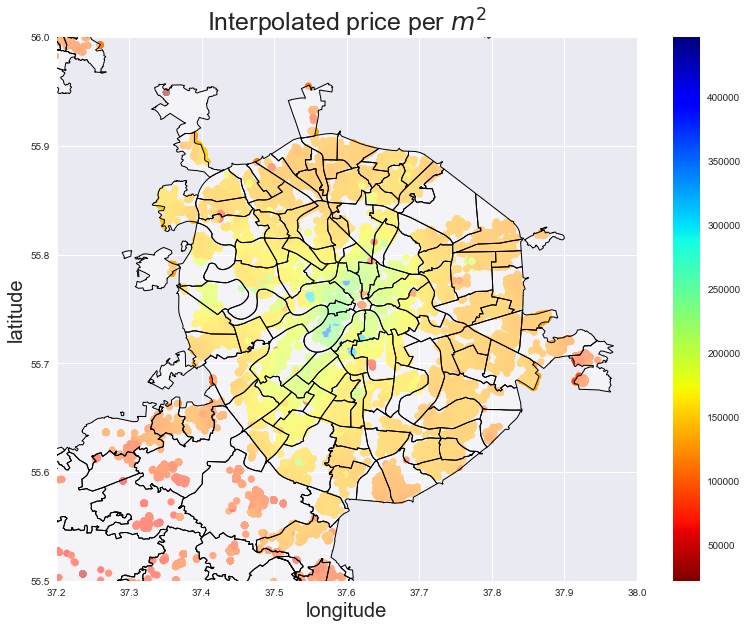

In [15]:
fig, ax = plt.subplots(1, figsize=(13, 10))
geo_df['geometry'].plot(color='white', ax=ax)#,figsize=(20,10))
plt.scatter(data.lon, data.lat, c=data['psq_interp'], cmap='jet_r')
plt.colorbar()
plt.title('Interpolated price per $m^2$', fontsize=25)
plt.xlabel('longitude', fontsize=20)
plt.ylabel('latitude', fontsize=20)
plt.ylim(55.5,56)
plt.xlim(37.2,38)
plt.show()

# XGBoost model

Now that we have a set of features, we are ready to put them into XGBoost for price prediction.  

In [16]:
data.drop(['lat','lon'], axis=1, inplace=True)

# separate training and test data
train = data[ data['testdata'] == False ]
test = data[ data['testdata'] == True ]

train.drop(['testdata'], axis=1, inplace=True)
test.drop(['testdata'], axis=1, inplace=True)

y_train = train['price_doc']
x_train = train.drop(['price_doc'], axis=1)
y_test = test['price_doc']
x_test = test.drop(['price_doc'], axis=1)

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Implement XGBoost

In [ ]:
import xgboost as xgb

xgb_params = {
   'eta': 0.05,
   'max_depth': 5,
   'subsample': 0.7,
   'colsample_bytree': 0.7,
   'objective': 'reg:linear',
   'eval_metric': 'rmse',
   'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)

# conduct cross-validation with 10 folds for hyperparameter tuning
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds=50,
   verbose_eval=50, show_stdv=False, nfold=10)

num_boost_rounds = len(cv_output) #676
final_rmse = cv_output['test-rmse-mean'].iloc[-1]

print('Boost rounds: ', num_boost_rounds)
print('Final RMSLE: ', str('%.5f' % final_rmse))

[0]	train-rmse:8.1833e+06	test-rmse:8.18538e+06
[50]	train-rmse:2.32477e+06	test-rmse:2.71173e+06
[100]	train-rmse:2.07206e+06	test-rmse:2.61715e+06
[150]	train-rmse:1.98333e+06	test-rmse:2.59689e+06
[200]	train-rmse:1.91036e+06	test-rmse:2.58704e+06
[250]	train-rmse:1.84469e+06	test-rmse:2.57796e+06
[300]	train-rmse:1.78036e+06	test-rmse:2.57361e+06
[350]	train-rmse:1.72265e+06	test-rmse:2.57018e+06
[400]	train-rmse:1.66935e+06	test-rmse:2.56952e+06
[450]	train-rmse:1.62096e+06	test-rmse:2.56887e+06
[500]	train-rmse:1.57349e+06	test-rmse:2.56856e+06
[550]	train-rmse:1.52964e+06	test-rmse:2.56639e+06
[600]	train-rmse:1.4882e+06	test-rmse:2.56445e+06
[650]	train-rmse:1.44868e+06	test-rmse:2.56338e+06
[700]	train-rmse:1.41004e+06	test-rmse:2.56232e+06
[750]	train-rmse:1.37413e+06	test-rmse:2.56146e+06
[800]	train-rmse:1.34006e+06	test-rmse:2.56133e+06
[850]	train-rmse:1.30803e+06	test-rmse:2.56195e+06
Boost rounds:  835
Final RMSLE:  2561137.57500


In [ ]:
# choose the best model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

## Feature importance

Plotting the F-score corresponding to each feature tells us how important it is in the XGBoost model.

In [ ]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
plt.figure()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sn.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")
plt.show()
print(features[['features', 'importance']])

As expected, the interpolated price and price/$m^2$ are at the top of the list, as well as full_sq (the total property area), life_sq (the living area), and kitch_sq (the kitchen area).

## Get results of XGBoost model

In [ ]:
# get matrix
dtest = xgb.DMatrix(x_test)

# get results
yres = model.predict(dtest)

result = pd.DataFrame(yres, index=y_test.index, columns=['price_doc'])
result.index.name = 'id'
print(result.head())

In [ ]:
# output to csv (for competition)
#outname = '../results/submission_xgb_' + datetime.now().strftime("%Y%m%d_%H%M") + '_' + str('%.4f' % final_rmse) + '.csv'
#result.to_csv(outname)

# Discussion

Now we compare the modeling results to the known test values.

In [ ]:
# get difference between test values and results
diff = result.price_doc - y_test
resid = diff/y_test

In [ ]:
# get rmse between test values and model results
rmse = np.sqrt((diff.values**2).mean())
print('Root Mean Square Error: ', rmse)
print('Mean true price: ', y_test.mean())

# plot residuals
plt.figure()
plt.hist(resid[resid.values<10].values, bins=100)
plt.xlabel('residual (rubles)', fontsize=20)
plt.ylabel('number of entries', fontsize=20)
plt.yscale('log')
plt.show()

Most of the residuals are between -1 and 1, as expected.  However, there is a large tail going into values up to 100.  To be investigated further -- it probably has to do with the artificial price reductions for investment sales.

In [ ]:
idx = resid[resid.values<10].index

# residuals vs. true value
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.scatter(y_test[idx], resid[idx].values)
plt.xlabel('true price (rubles)', fontsize=20)
plt.ylabel('residual (rubles)', fontsize=20)
plt.title('residuals vs. true price', fontsize=25)

plt.subplot(2,2,2)
plt.scatter(x_test.loc[idx].full_sq, resid[idx].values)
plt.xlabel('full area ($m^2$)', fontsize=20)
plt.ylabel('residual (rubles)', fontsize=20)
plt.title('residuals vs. full area', fontsize=25)

plt.subplot(2,2,3)
plt.scatter(x_test.loc[idx].psq_interp, resid[idx].values)
plt.xlabel('interpolated price/area (rubles/$m^2$)', fontsize=20)
plt.ylabel('residual (rubles)', fontsize=20)
plt.title('residuals vs. interpolated price/area', fontsize=25)

plt.subplot(2,2,4)
plt.scatter(x_test.loc[idx].price_interp, resid[idx].values)
plt.xlabel('interpolated price (rubles)', fontsize=20)
plt.ylabel('residual (rubles)', fontsize=20)
plt.title('residuals vs. interpolated price', fontsize=25)
plt.show()

These plots show no major correlations, which indicates that the XGBoost model is reasonably unbiased as a function of price and area.

The largest residuals are found at low true price, which may point to artificially reduced investment property prices as the issue.  In future iterations of this algorithm, we may investigate if it's possible to predict when a sale price is artificially lowered, so that the effect can be addressed in the model.

The RMSE of the model is about 2.5 million rubles, where 7.1 million rubles is the average sale price.  This indicates that our model can predict the price of a property to within about 30% on average.